In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('clean_data.csv')

# Convert 'Date' to datetime and extract year, month, and day
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace=True)  # Drop the original 'Date' column

In [3]:
# Selecting features
FEATURES = ['Year', 'Month', 'Day', 'Size', 'Type', 'Dept', 'Store', 'Weekly_Sales' , 'IsHoliday']
df = df[FEATURES]

# One-hot encoding for categorical features
df = pd.get_dummies(df, columns=['Type', 'Dept', 'Store'])

# Scaling the features
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)


In [4]:
# Preparing data for LSTM
target_index = df.columns.get_loc('Weekly_Sales')
X, y = df_scaled[:, np.arange(df_scaled.shape[1]) != target_index], df_scaled[:, target_index]

# Reshape input to be [samples, time steps, features]
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split the data into training and testing sets
split_index = int(0.8 * len(df))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [5]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=2)



Epoch 1/5

10506/10506 - 18s - loss: 1.4729e-04 - val_loss: 3.1147e-04 - 18s/epoch - 2ms/step
Epoch 2/5
10506/10506 - 15s - loss: 9.8626e-05 - val_loss: 4.2294e-04 - 15s/epoch - 1ms/step
Epoch 3/5
10506/10506 - 14s - loss: 8.3534e-05 - val_loss: 4.8696e-04 - 14s/epoch - 1ms/step
Epoch 4/5
10506/10506 - 14s - loss: 7.6156e-05 - val_loss: 6.2180e-04 - 14s/epoch - 1ms/step
Epoch 5/5
10506/10506 - 14s - loss: 7.0489e-05 - val_loss: 6.0374e-04 - 14s/epoch - 1ms/step


In [14]:
# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

Test Loss: 0.000603740569204092


In [6]:
# Making predictions
y_pred = model.predict(X_test)





2627/2627 [==============================] - 2s 845us/step


In [7]:
# Filter the original dataframe for the validation period
val = df.iloc[split_index:]
val['prediction'] = y_pred.reshape(-1)


# Reshape y_test for concatenation
y_test_reshaped = y_test.reshape(-1, 1)

# Prepare the array for inverse transformation for y_test
num_features = df_scaled.shape[1] - 1  # Total features excluding 'Weekly_Sales'
X_test_features = X_test.reshape(X_test.shape[0], num_features)
test_data_combined = np.concatenate((X_test_features, y_test_reshaped), axis=1)
y_test_rescaled = scaler.inverse_transform(test_data_combined)[:, -1]

# Prepare the array for inverse transformation for y_pred
pred_data_combined = np.concatenate((X_test_features, val['prediction'].values.reshape(-1, 1)), axis=1)
y_pred_rescaled = scaler.inverse_transform(pred_data_combined)[:, -1]

C:\Users\Samee\AppData\Local\Temp\ipykernel_22948\3079833101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = y_pred.reshape(-1)


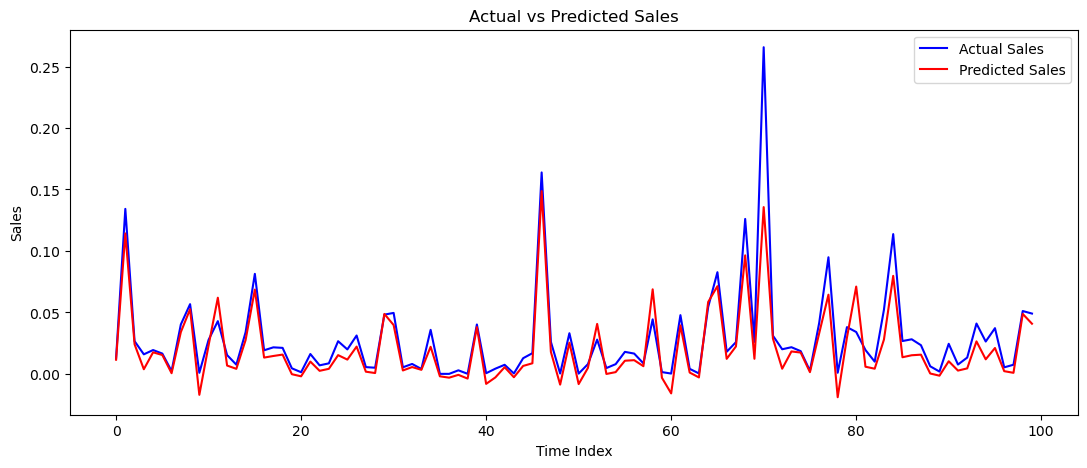

In [12]:

# Visualization using Seaborn
plt.figure(figsize=(13, 5))
sns.lineplot(x=np.arange(100), y=y_test_rescaled[:100], label='Actual Sales', color='blue')
sns.lineplot(x=np.arange(100), y=y_pred_rescaled[:100], label='Predicted Sales', color='red')  
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time Index')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


sales_comparison = pd.DataFrame({
    'Actual Sales': y_test_rescaled, 
    'Predicted Sales': y_pred_rescaled
})


print(sales_comparison.head())

   Actual Sales  Predicted Sales
0      0.012468         0.011518
1      0.134194         0.114251
2      0.026605         0.024077
3      0.015898         0.003761
4      0.019377         0.017525


In [16]:
# Calculate Mean Squared Error
mse_lstm = mean_squared_error(y_test_rescaled, y_pred_rescaled)

# Calculate R-squared Score
r2_lstm = r2_score(y_test_rescaled, y_pred_rescaled)

# Print the results

print("Mean Squared Error:", mse_lstm)
print("R-squared Score:", r2_lstm)

Mean Squared Error: 0.0006037408624449612
R-squared Score: 0.16447511577148322


In [19]:
r2 = 0.16447511577148322
# Converting R-squared score to a percentage
r2_percentage = r2 * 100

# Printing the accuracy as a percentage
print("Accuracy: {:.2f}%".format(r2_percentage))


Accuracy: 16.45%
